In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # 라벨 인코더
from sklearn.preprocessing import OneHotEncoder

from ProBinModel import *


TrainDF = pd.read_csv('TrainDF.csv')
TestDF = pd.read_csv('TestDF.csv')


# 짜투리 전처리 location drop

# 데이터 날짜 -> 시간으로 변경
TrainDF['Date'] = TrainDF['Date'].str[-11:]
TrainDF['Time'] = pd.to_datetime(TrainDF['Date'], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')
TrainDF.drop(['Unnamed: 0','Date','Location'], inplace=True, axis=1)
TrainDF['Time'] = pd.to_datetime(TrainDF['Time'], format='%H:%M:%S')
TestDF['Date'] = TestDF['Date'].str[-11:]
TestDF['Time'] = pd.to_datetime(TestDF['Date'], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')
TestDF.drop(['Unnamed: 0','Date','Location'], inplace=True, axis=1)
TestDF['Time'] = pd.to_datetime(TrainDF['Time'], format='%H:%M:%S')

# 시간 텐서화 목적으로 다 나눠버리기 ...~$ㄻㄴㄹㄴㅇ ㅠㅠㅠㅠㅠㅠㅠ
TrainDF['hour'] = TrainDF['Time'].dt.hour
TrainDF['minute'] = TrainDF['Time'].dt.minute
TrainDF['second'] = TrainDF['Time'].dt.second
TrainDF.drop(['Time'], inplace=True, axis=1)

TestDF['hour'] = TestDF['Time'].dt.hour
TestDF['minute'] = TestDF['Time'].dt.minute
TestDF['second'] = TestDF['Time'].dt.second
TestDF.drop(['Time'], inplace=True, axis=1)

# IUCR는 라벨 인코더로, Location Description는 원핫 인코더로.
# IUCR
Labelencoder = LabelEncoder()
TrainDF['IUCR'] = Labelencoder.fit_transform(TrainDF['IUCR'])
TestDF['IUCR'] = Labelencoder.fit_transform(TestDF['IUCR'])

# 
# OHencoder = OneHotEncoder(sparse=False)
OHtemp = pd.get_dummies(TrainDF['Location Description'])
TrainDF.drop(['Location Description'], axis=1, inplace=True)
TrainDF = pd.concat([TrainDF, OHtemp], axis=1)

OHtemp = pd.get_dummies(TestDF['Location Description'])
TestDF.drop(['Location Description'], axis=1, inplace=True)
TestDF = pd.concat([TestDF, OHtemp], axis=1)

In [2]:
# # 자체 Train_test_split
X_train = TrainDF.iloc[:, TrainDF.columns != TrainDF.columns[1]]
y_train = TrainDF[['Arrest']]

X_test = TestDF.iloc[:, TestDF.columns != TestDF.columns[1]]
y_test = TestDF[['Arrest']]

torch.Size([1, 33]) torch.Size([1, 1]) tensor([[ 0.,  6., 21., 71.,  1.,  0.,  0.,  6., 30.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.]]) tensor([[0.]])


c:\Users\kjy19\anaconda3\envs\TORCH_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\Users\kjy19\anaconda3\envs\TORCH_38\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


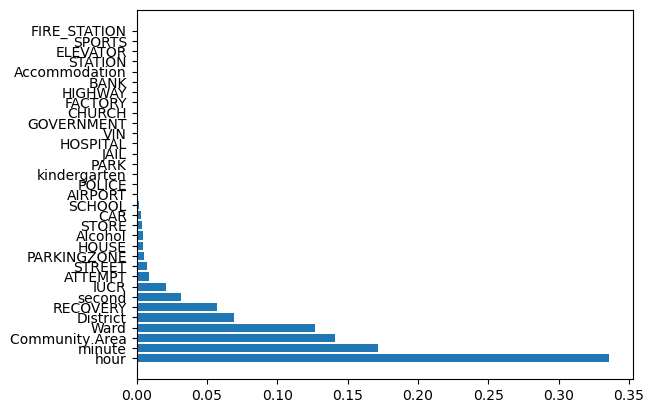

In [3]:
VehDS = BinDataset(X_train, y_train)
VehDL = DataLoader(VehDS)
# print(VehDL)
for feature, label in VehDL:
    print(feature.shape, label.shape, feature, label)
    break


EPOCH = 50
BATCH_SIZE = 10
BATCH_CNT = X_train.shape[0]//BATCH_SIZE # 선택사항 - 코드에 넣을 수도 있음
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

model = BinClaModel()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)

trainDS = BinDataset(X_train, y_train)
valDS = BinDataset(X_val, y_val)
testDS = BinDataset(X_test, y_test)
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience =5, verbose = True)
reqLoss = nn.BCELoss()

from sklearn.ensemble import RandomForestClassifier
import pandas as pd


# 모델 훈련
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 피쳐 중요도 추출
importances = model.feature_importances_

# 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# print(feature_importance_df)
# type(feature_importance_df)
plt.barh(feature_importance_df.loc[:,'Feature'], feature_importance_df.loc[:,'Importance'])
plt.show()

In [4]:
TotalDF = pd.read_csv("Motor_Vehicle_Theft.csv")


TotalDF['Arrest'].value_counts()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,70,12045468,JD225478,05/05/2020 10:00:00 PM,104XX S AVENUE M,910,MOTOR VEHICLE THEFT,AUTOMOBILE,DRIVEWAY - RESIDENTIAL,False,False,432,4.0,10.0,52.0,7,1201505.0,1836426.0,2020,05/12/2020 03:42:00 PM,41.705902,-87.537707,"(41.705902269, -87.537707456)"
1,98,12146876,JD345261,08/10/2020 08:30:00 AM,030XX N CLARK ST,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1934,19.0,44.0,6.0,7,1170665.0,1920334.0,2020,08/28/2020 03:40:39 PM,41.936880,-87.648190,"(41.936880447, -87.648190373)"
2,121,11651620,JC220143,11/14/2018 01:00:00 PM,025XX W LEXINGTON ST,910,MOTOR VEHICLE THEFT,AUTOMOBILE,PARKING LOT/GARAGE(NON.RESID.),False,False,1135,11.0,28.0,28.0,7,NaN,NaN,2018,04/11/2019 04:07:22 PM,NaN,NaN,NaN
3,163,11652865,JC221541,11/04/2018 12:01:00 AM,007XX N SACRAMENTO BLVD,910,MOTOR VEHICLE THEFT,AUTOMOBILE,PARKING LOT/GARAGE(NON.RESID.),False,False,1221,12.0,27.0,23.0,7,NaN,NaN,2018,04/13/2019 04:01:56 PM,NaN,NaN,NaN
4,246,12169088,JD371131,09/18/2020 12:01:00 AM,075XX S PHILLIPS AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,421,4.0,7.0,43.0,7,1193843.0,1855380.0,2020,09/25/2020 03:42:30 PM,41.758105,-87.565145,"(41.75810458, -87.565145103)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411395,8157236,12058920,JD242021,05/25/2020 02:20:00 AM,067XX S PULASKI RD,910,MOTOR VEHICLE THEFT,AUTOMOBILE,GAS STATION,False,False,833,8.0,13.0,65.0,7,1150858.0,1859776.0,2020,06/01/2020 03:41:06 PM,41.771113,-87.722567,"(41.771113236, -87.722567122)"
411396,8157240,12153210,JD352712,08/27/2020 07:30:00 AM,051XX S CICERO AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,AIRPORT EXTERIOR - SECURE AREA,False,False,814,8.0,14.0,56.0,7,1145228.0,1870076.0,2020,09/04/2020 03:39:55 PM,41.799486,-87.742946,"(41.799486, -87.742945744)"
411397,8157250,12178409,JD382035,09/26/2020 12:00:00 PM,070XX W 60TH ST,915,MOTOR VEHICLE THEFT,"TRUCK, BUS, MOTOR HOME",STREET,False,False,812,8.0,23.0,64.0,7,1130585.0,1863929.0,2020,10/03/2020 03:41:02 PM,41.782881,-87.796787,"(41.782880913, -87.796787321)"
411398,8157276,12200908,JD408091,10/22/2020 05:00:00 PM,026XX N MONTICELLO AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,2524,25.0,35.0,22.0,7,1151598.0,1917357.0,2020,12/17/2020 03:40:05 PM,41.929108,-87.718343,"(41.929108084, -87.718342896)"
